In [1]:
from manim import *
import jupyter_capture_output

video_scene = f" -v WARNING --disable_caching ct_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s ct_Scene"

Manim Community v0.17.3

Jupyter Capture Output v0.0.11


In [2]:
# analytical values
x0 = 3
omega0 = PI / 2

gamma_underdamped = omega0 / 16
gamma_underdamped_2 = omega0 / 4
gamma_critically_damped = omega0
gamma_overdamped = 4 * omega0


# speed of the paper under the pendulum
def y_speed(t):
    return t / 2


# undampeded oscillation
def x_undamped(t):
    return x0 * np.cos(omega0 * t)


# underdamped oscillation
def x_underdamped(t):
    return x0 * np.cos(np.sqrt(omega0**2-gamma_underdamped) * t) * np.exp(-gamma_underdamped * t)

def x_underdamped_2(t):
    return x0 * np.cos(np.sqrt(omega0**2-gamma_underdamped_2) * t) * np.exp(-gamma_underdamped_2 * t)


# critically damped oscillation
def x_critically_damped(t):
    return x0 * (1 + gamma_critically_damped*t) * np.exp(-gamma_critically_damped * t)


# overdamped oscillation 
def x_overdamped(t):
    A = x0 / 2 * (1 + gamma_overdamped / np.sqrt(gamma_overdamped**2 - omega0**2))
    B = x0 / 2 * (1 +- gamma_overdamped / np.sqrt(gamma_overdamped**2 - omega0**2))
    return A * np.exp((-gamma_overdamped + np.sqrt(gamma_overdamped**2 - omega0**2)) * t) + B * np.exp((-gamma_overdamped - np.sqrt(gamma_overdamped**2 - omega0**2)) * t)


# creates noise of the strength of sigma
def noise_for_coord(x, y, sigma_noise, leaking_rate):
    sand_list = []
    if leaking_rate < 1:
        rand_uni = np.random.uniform()
        if leaking_rate > rand_uni:
            x_dev = np.random.normal(x, sigma_noise / 40)
            y_dev = np.random.normal(y, sigma_noise / 40)
            sand_list.append((x_dev, y_dev, 0)) 
    else:  
        for i in range(int(leaking_rate)):
            x_dev = np.random.normal(x, sigma_noise / 40)
            y_dev = np.random.normal(y, sigma_noise / 40)
            sand_list.append((x_dev, y_dev, 0))
    return sand_list

Output saved by creating file at animations/christmas_tree/christmas_tree.mp4.


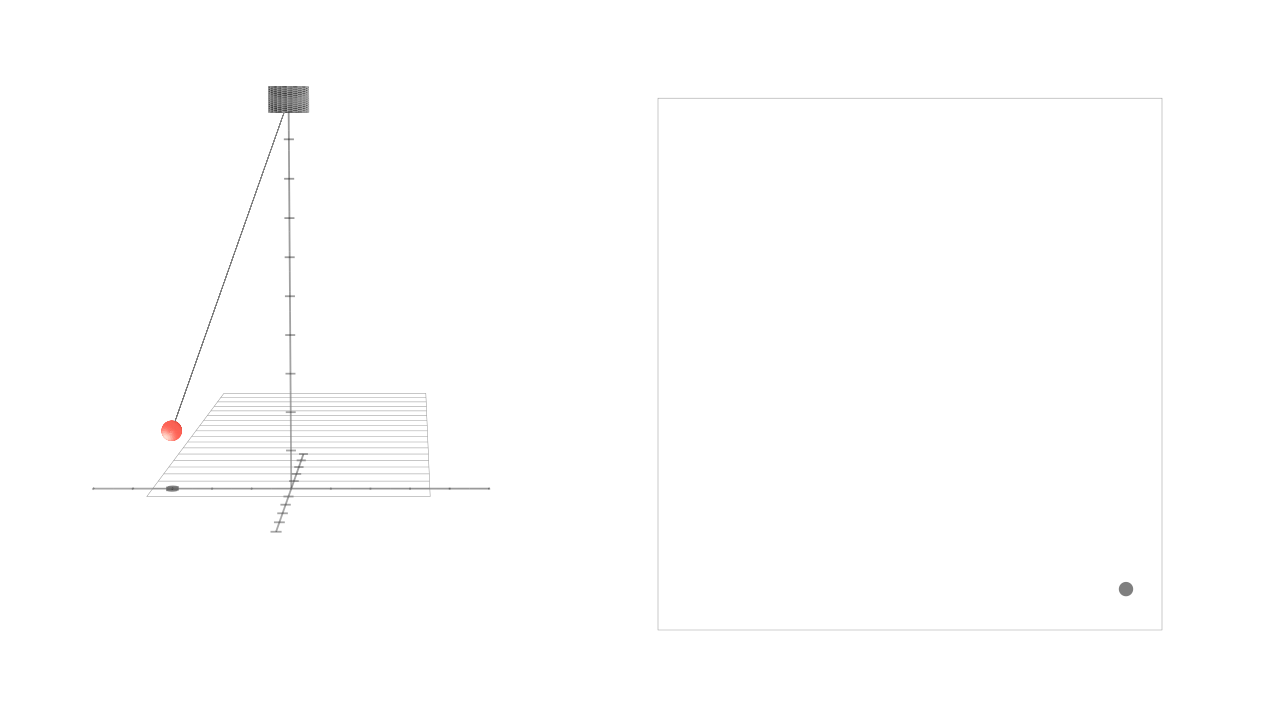

In [28]:
%%capture_video --path "animations/christmas_tree/christmas_tree.mp4"
%%manim -qm --fps 10 $video_scene


# function in use for the drawing
used_function = x_underdamped


class ct_Scene(ThreeDScene):
    def construct(self):
        center_of_frame = np.array([2.5, -0.5, 20])
        self.camera.background_color = WHITE
        self.camera.frame_center = center_of_frame


        # 3D coordinate system with spherical pendulum
        CO3D = [-5, -1, -8]
        CO3D_x_range = (-5, 5, 1)
        CO3D_y_range = (-5, 5, 1)
        CO3D_z_range = (0, 10.25, 1)
        ax = ThreeDAxes(
            x_range = CO3D_x_range, y_range = CO3D_y_range, z_range = CO3D_z_range, x_length = 8, y_length = 8, z_length = 8, axis_config = {'stroke_color': BLACK}, 
            z_axis_config = {'color': BLACK}, tips = False,
            ).set_opacity(0.4)
    

        # 2D coordination system
        ax1 = Axes(x_range = [-5, 5, 1], y_range = [-1, 10, 1], x_length = 8, y_length = 5, tips = False, axis_config = {"stroke_opacity": 0.5, "stroke_color": BLACK,}).move_to(center_of_frame + np.array([5.5, -1, 0])).set_opacity(0.25)


        # spherical pendulum anchor
        prism_x = Prism(dimensions = [2, 0.125, 0.125], fill_color = BLACK, stroke_color = GREY).set_opacity(0.75).move_to(ax.c2p(0, 0, 10))
        prism_y = Prism(dimensions = [0.125, 2, 0.125], fill_color = BLACK, stroke_color = GREY).set_opacity(0.75).move_to(ax.c2p(0, 0, 10))
        cylinder = Cylinder(radius = 0.4, height = 0.5, color = BLACK, fill_color = BLACK, resolution = (24, 24), checkerboard_colors = [BLACK, GREY]).move_to(ax.c2p(0, 0, 10))
        spherical_pendulum_ax_group = VGroup(ax, cylinder).rotate(
            axis = [0, 0, 1], angle = -PI,
                ).rotate(axis = [1, 0, 0], angle = 6.125*PI/4)


        # creates the pendulum in ax
        def create_pendulum(x):
            pendulum_group = VGroup()
            ball_size = 0.2
            r = 9
            z = 10 - np.sqrt(r**2 - x**2)
            line = Line3D(start = np.array(ax.c2p(0, 0, 10)), end = np.array(ax.c2p(x, 0, z)), color = GREY, thickness = 0.001)
            sphere = Dot3D(point = ax.c2p(x, 0, z), radius = ball_size, resolution = (20, 20),).set_color(RED)
            shadow = ax.plot_parametric_curve(lambda phi: np.array([0.1*np.cos(phi), 0.1*np.sin(phi), z]), t_range = [0, 2*PI], stroke_opacity = 0.5, stroke_width = 5, color = BLACK).move_to(ax.c2p(x, 0, 0))
            pendulum_group.add(line, sphere, shadow)
            return pendulum_group


        # paper
        paper_x_min = -3.5
        paper_x_max = 3.5
        paper_y_min = -17
        paper_y_max = 1
        pos_list = [
            ax.c2p(paper_x_min, paper_y_min, 0),
            ax.c2p(paper_x_min, paper_y_max, 0),
            ax.c2p(paper_x_max, paper_y_max, 0),
            ax.c2p(paper_x_max, paper_y_min, 0),
        ]
        paper_rect_group = VGroup()
        y_range = paper_y_max - paper_y_min
        for y_i in range(1, int(y_range)):
            y_range = paper_y_max - paper_y_min
            increment_line = Line(start = ax.c2p(paper_x_min, paper_y_min + y_i, 0), end = ax.c2p(paper_x_max, paper_y_min + y_i, 0), color = GREY, stroke_width = 0.5)
            paper_rect_group.add(increment_line)

        paper_rect = Polygon(*pos_list, color = GREY, stroke_width = 0.5)
        paper_rect_2D = Polygon(ax1.c2p(paper_x_min, -1, 0), ax1.c2p(paper_x_min, 12, 0), ax1.c2p(paper_x_max, 12, 0), ax1.c2p(paper_x_max, -1, 0), color = GREY, stroke_width = 0.5)
        #paper_rect.base_coord = rect_paper.get_center()
        paper_rect_group.add(paper_rect)
        paper_rect_group.base_coord = paper_rect_group.get_center()
        #print(ax.c2p(*paper_rect_group.base_coord))


        # constant shift updater
        fps_correction = 6      # (6 for 10 fps, 1 for 60 fps)
        def shift2_updater(mobject):
            mobject.shift(ax.c2p(0, 1 / 40 * fps_correction, 0) - ax.c2p(0, 0, 0))


        sigma_noise = 5
        leaking_rate = 1 * fps_correction


        pendulum = create_pendulum(3)
        shadow = Dot(point = ax1.c2p(x_underdamped(0), y_speed(0), 0), color = BLACK, fill_opacity = 0.5)


        # pendulum updater
        def pendulum_updater(pendulum):
            t = t_tracker.get_value()
            x = used_function(t)
            y = y_speed(t)
            sand_list = noise_for_coord(x, y, sigma_noise, leaking_rate)
            for coord in sand_list:
                self.add(Dot(point = ax1.c2p(*coord), radius = 0.025, color = GREEN))
                dot3D = Dot3D(point = ax.c2p(-coord[0], 0, 0), radius = 0.025, color = GREEN)
                self.add(dot3D)
                dot3D.add_updater(shift2_updater)
            pendulum.become(create_pendulum(-x))


        def shadow_updater(shadow):
            t = t_tracker.get_value()
            x = used_function(t)
            y = y_speed(t)
            shadow.move_to(ax1.c2p(x, y, 0))


        self.add(cylinder)
        self.add(pendulum)
        self.add(shadow)
        self.add(paper_rect_group, paper_rect_2D)

        self.add(ax)
        #self.add(ax1)

        # t_tracker = ValueTracker(0)
        # pendulum.add_updater(pendulum_updater)
        # shadow.add_updater(shadow_updater)
        # paper_rect_group.add_updater(shift2_updater)
        # self.play(t_tracker.animate.set_value(3*2*PI + PI/2), rate_func = linear, run_time = 10)
        # pendulum.remove_updater(pendulum_updater)
        # shadow.remove_updater(shadow_updater)
        # self.wait(5)

In [23]:
%%capture_video --path "animations/christmas_tree/christmas_tree_right.mp4"
%%manim -qm --fps 60 $video_scene


class ct_Scene(Scene):
    def construct(self):
        self.camera.background_color = WHITE


        # ax grid positions
        left_ax = -4
        right_ax = 4
        top_ax = 1.75
        down_ax = -1.75
        
        ax_positions = [
            [left_ax, top_ax, 0],
            [right_ax, top_ax, 0],
            [left_ax, down_ax, 0],
            [right_ax, down_ax, 0]
        ]


        # ax properties
        ax_x_range = [-5, 5, 1]
        ax_y_range = [-1, 10, 1]
        ax_x_length = 8
        ax_y_length = 3


        # 2D coordination system
        ax1 = Axes(x_range = ax_x_range, y_range = [-1, 10, 1], x_length = ax_x_length, y_length = ax_y_length, tips = True, axis_config = {"stroke_opacity": 0.5, "stroke_color": BLACK}).set_opacity(0.25).move_to(ax_positions[0])
        ax2 = Axes(x_range = ax_x_range, y_range = [-1, 10, 1], x_length = ax_x_length, y_length = ax_y_length, tips = True, axis_config = {"stroke_opacity": 0.5, "stroke_color": BLACK}).set_opacity(0.25).move_to(ax_positions[1])
        ax3 = Axes(x_range = ax_x_range, y_range = [-1, 10, 1], x_length = ax_x_length, y_length = ax_y_length, tips = True, axis_config = {"stroke_opacity": 0.5, "stroke_color": BLACK}).set_opacity(0.25).move_to(ax_positions[2])
        ax4 = Axes(x_range = ax_x_range, y_range = [-1, 10, 1], x_length = ax_x_length, y_length = ax_y_length, tips = True, axis_config = {"stroke_opacity": 0.5, "stroke_color": BLACK}).set_opacity(0.25).move_to(ax_positions[3])


        # shadow updater
        def shadow_updater(shadow):
            ax_shad = shadow.properties[0]
            func = shadow.properties[1]
            t = t_tracker.get_value()
            x = func(t)
            y = y_speed(t)
            sand_list = noise_for_coord(x, y, sigma_noise = shadow.properties[2], leaking_rate = shadow.properties[3])
            for coord in sand_list:
                self.add(Dot(point = ax_shad.c2p(*coord), radius = 0.025, color = GREEN))
            shadow.move_to(ax_shad.c2p(x, y, 0))


        sigma_noise = 5
        leaking_rate = 2


        shadow_1 = Dot(point = ax1.c2p(x_underdamped(0), y_speed(0), 0), color = BLACK, fill_opacity = 0.5)
        shadow_1.properties = (ax1, x_underdamped, sigma_noise, leaking_rate)

        shadow_2 = Dot(point = ax2.c2p(x_underdamped(0), y_speed(0), 0), color = BLACK, fill_opacity = 0.5)
        shadow_2.properties = (ax2, x_underdamped, sigma_noise, leaking_rate / 6)

        shadow_3 = Dot(point = ax3.c2p(x_underdamped_2(0), y_speed(0), 0), color = BLACK, fill_opacity = 0.5)
        shadow_3.properties = (ax3, x_underdamped, sigma_noise / 3, leaking_rate)

        shadow_4 = Dot(point = ax4.c2p(x_underdamped(0), y_speed(0), 0), color = BLACK, fill_opacity = 0.5)
        shadow_4.properties = (ax4, x_underdamped_2, sigma_noise, leaking_rate)


        self.add(ax1, ax2, ax3, ax4)
        self.add(shadow_1, shadow_2, shadow_3, shadow_4)
        t_tracker = ValueTracker(0)
        shadow_1.add_updater(shadow_updater)
        shadow_2.add_updater(shadow_updater)
        shadow_3.add_updater(shadow_updater)
        shadow_4.add_updater(shadow_updater)
        self.play(t_tracker.animate.set_value(3*2*PI + PI/2), rate_func = linear, run_time = 10)
        shadow_1.remove_updater(shadow_updater)
        shadow_2.remove_updater(shadow_updater)
        shadow_3.remove_updater(shadow_updater)
        shadow_4.remove_updater(shadow_updater)
        self.wait(5)

Output saved by overwring previous file at animations/christmas_tree/christmas_tree_right.mp4.
